<a href="https://colab.research.google.com/github/aapokrki/t_xai_project/blob/main/XRAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XRAI method


In [ ]:
# Install dependencies
# Note: You will receive the following error when executing this cell:
# WARNING: The following packages were previously imported in this runtime: [PIL]
# You must restart the runtime in order to use newly installed versions.
# Simply click on RESTART SESSION and restart the session and then continue with the execution of the next cell.
!pip install captum
!pip install numpy --upgrade --force-reinstall --no-cache-dir
!pip install torchvision --upgrade --force-reinstall --no-cache-dir



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from captum.attr import IntegratedGradients
from skimage.segmentation import felzenszwalb
from PIL import Image
from skimage.morphology import dilation, square
import matplotlib.gridspec as gridspec

In [ ]:
def load_data(batch_size=256, valid_size=0.15, num_workers=0):
   # transformation pipleine from pytorch vgg16 documentation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
    ])

    train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

    # create dataloaders for batching
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader,transform


def test_model(model, test_loader, device, classes, criterion):
  model = model.to(device)

  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      for i in range(len(correct)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
  # average test loss
  test_loss /= len(test_loader.dataset)
  print(f'Test Loss: {test_loss:.6f}\n')
  for i in range(10):
      if class_total[i] > 0:
          print(f'Test Accuracy of {classes[i]:5s}: {100 * class_correct[i] / class_total[i]:.2f}%')
  overall_acc = 100. * np.sum(class_correct) / np.sum(class_total)
  print(f'Test Accuracy (Overall): {overall_acc:.2f}%')

In [ ]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
print(model)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg16_bn-6ee7ea24.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg16_bn-6ee7ea24.pt
100%|██████████| 58.3M/58.3M [00:01<00:00, 35.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
train_loader, test_loader,tranform= load_data(batch_size=256, valid_size=0.15, num_workers=0)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()

#test_model(model, test_loader, device, classes, criterion)

100%|██████████| 170M/170M [00:06<00:00, 27.3MB/s]


cpu
Test Loss: 0.326345

Test Accuracy of airplane: 95.90%
Test Accuracy of automobile: 97.30%
Test Accuracy of bird : 91.30%
Test Accuracy of cat  : 87.20%
Test Accuracy of deer : 94.50%
Test Accuracy of dog  : 90.10%
Test Accuracy of frog : 96.10%
Test Accuracy of horse: 97.00%
Test Accuracy of ship : 96.30%
Test Accuracy of truck: 95.90%
Test Accuracy (Overall): 94.16%


In [ ]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:

#Get indices of the first 10 images of each class
def collect_indices(labels,num_classes,max_per_class,image_tensor,model):
  indices_per_class = [[] for _ in range(num_classes)]
  for idx, label in enumerate(labels):

      label = label.item()
      output=model(image_tensor[idx].unsqueeze(0))
      pred_label = output.argmax(dim=1).item()

      if pred_label!=label:
          continue
      if len(indices_per_class[label]) < max_per_class:
          indices_per_class[label].append(idx)
      if all(len(lst) == max_per_class for lst in indices_per_class):
          break

  indices = [idx for class_indices in indices_per_class for idx in class_indices]
  indices = torch.tensor(indices)

  return indices

def get_label(image):
  output = model(image)

  probs = torch.nn.functional.softmax(output, dim=1)

  confidence, predicted_class = torch.max(probs, 1)
  pred_label = output.argmax(dim=1).item()
  return pred_label

  #felzenswalb segmentation
def segment_image(image,pred_label,model):

  ig = IntegratedGradients(model)
  attributions = ig.attribute(image, target=pred_label)
  attr_map = attributions.squeeze().sum(dim=0).detach().cpu().numpy()

  image_np = image.squeeze().permute(1, 2, 0).numpy()
  image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
  segments = felzenszwalb(image_np, scale=30, sigma=0.3, min_size=20)

  selem = square(3)
  segments = dilation(segments, selem)
  segment_ids = np.unique(segments)
  segment_masks = [(segments == i) for i in segment_ids]
  return image_np, attr_map, segment_masks


def XRAI(image_np, attr_map, segment_masks,label):

  mask = np.zeros((32,32), dtype=bool)
  T = []
  S=np.ones((32,32), dtype=bool)

  #The algorithm from the paper
  while mask.sum() < 32*32 and S.sum()>0:
      best_gain = -np.inf
      best_segment = None

      for segment in segment_masks:
          for i in range(32):
              for j in range(32):
                  if segment[i,j]==mask[i,j]:
                      segment[i,j]=False
          if segment.sum()>0:
              gain = attr_map[segment].sum() / segment.sum()
          else:
              gain=-np.inf
          if gain > best_gain:
              best_gain = gain
              best_segment = segment
      for k in range(32):
          for l in range(32):
              if best_segment[k,l]==True and S[k,l]==True:
                  S[k,l]=False

      mask = np.logical_or(mask,best_segment)
      T.append(mask)
  return T

def get_explained_image(image_np,T,pred_label,model):
    explain_label=-1
    seg=-1
    #Run until the label is correct
    while explain_label!=pred_label:
        seg=seg+1
        area=round((T[seg].sum()/1024)*100,2)
        T[seg]=T[seg][...,np.newaxis]
        explained_image=image_np*T[seg]
        img_pil = Image.fromarray((explained_image * 255).astype('uint8'))
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
    ])
        img_tensor = transform(img_pil)
        img_tensor = img_tensor.unsqueeze(0)


        explain_output = model(img_tensor)
        explain_label = explain_output.argmax(dim=1).item()

    return explained_image,area


    images.append(image_np)
    images.append(T[seg]*image_np)
    cluster_titles.append('Label: ' + str(classes[pred_label])+'\n$\\Delta$ conf: '+ str(deltaconf)+'%, Area: '+ str(area)+'%')


def plot_images(images, titles,rows,cols):
  fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(cols * 8, rows * 4),
        squeeze=False
    )
  axes_flat = axes.flatten()
  for idx in range(len(images)):
        stacked_image = images[idx]
        axes_flat[idx].imshow(stacked_image)
        axes_flat[idx].set_title(titles[idx],fontsize=30)
        axes_flat[idx].axis('off')


  for idx in range(len(images), rows * cols):
      axes_flat[idx].axis('off')


  plt.subplots_adjust(
      wspace=0.05,
      hspace=0.05
  )
  plt.tight_layout()
  plt.show()


def run_XRAI(image_tensor, labels, num_classes, max_per_class,rows,cols,model):
  images=[]
  titles=[]
  indices=collect_indices(labels,num_classes,max_per_class,image_tensor,model)
  for idx in indices:
      image = image_tensor[idx].unsqueeze(0)
      pred_label = get_label(image)

      image_np, attr_map, segment_masks = segment_image(image,pred_label,model)
      T=XRAI(image_np, attr_map, segment_masks,pred_label)
      explained_image,area=get_explained_image(image_np,T,pred_label,model)
      images.append(np.hstack((image_np, explained_image)))
      titles.append('Label: ' + str(classes[pred_label])+'\narea: '+ str(area)+'%')
  plot=plot_images(images, titles,rows,cols)
  return plot


<ipython-input-12-2ea9994f3fa4>:40: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = square(3)


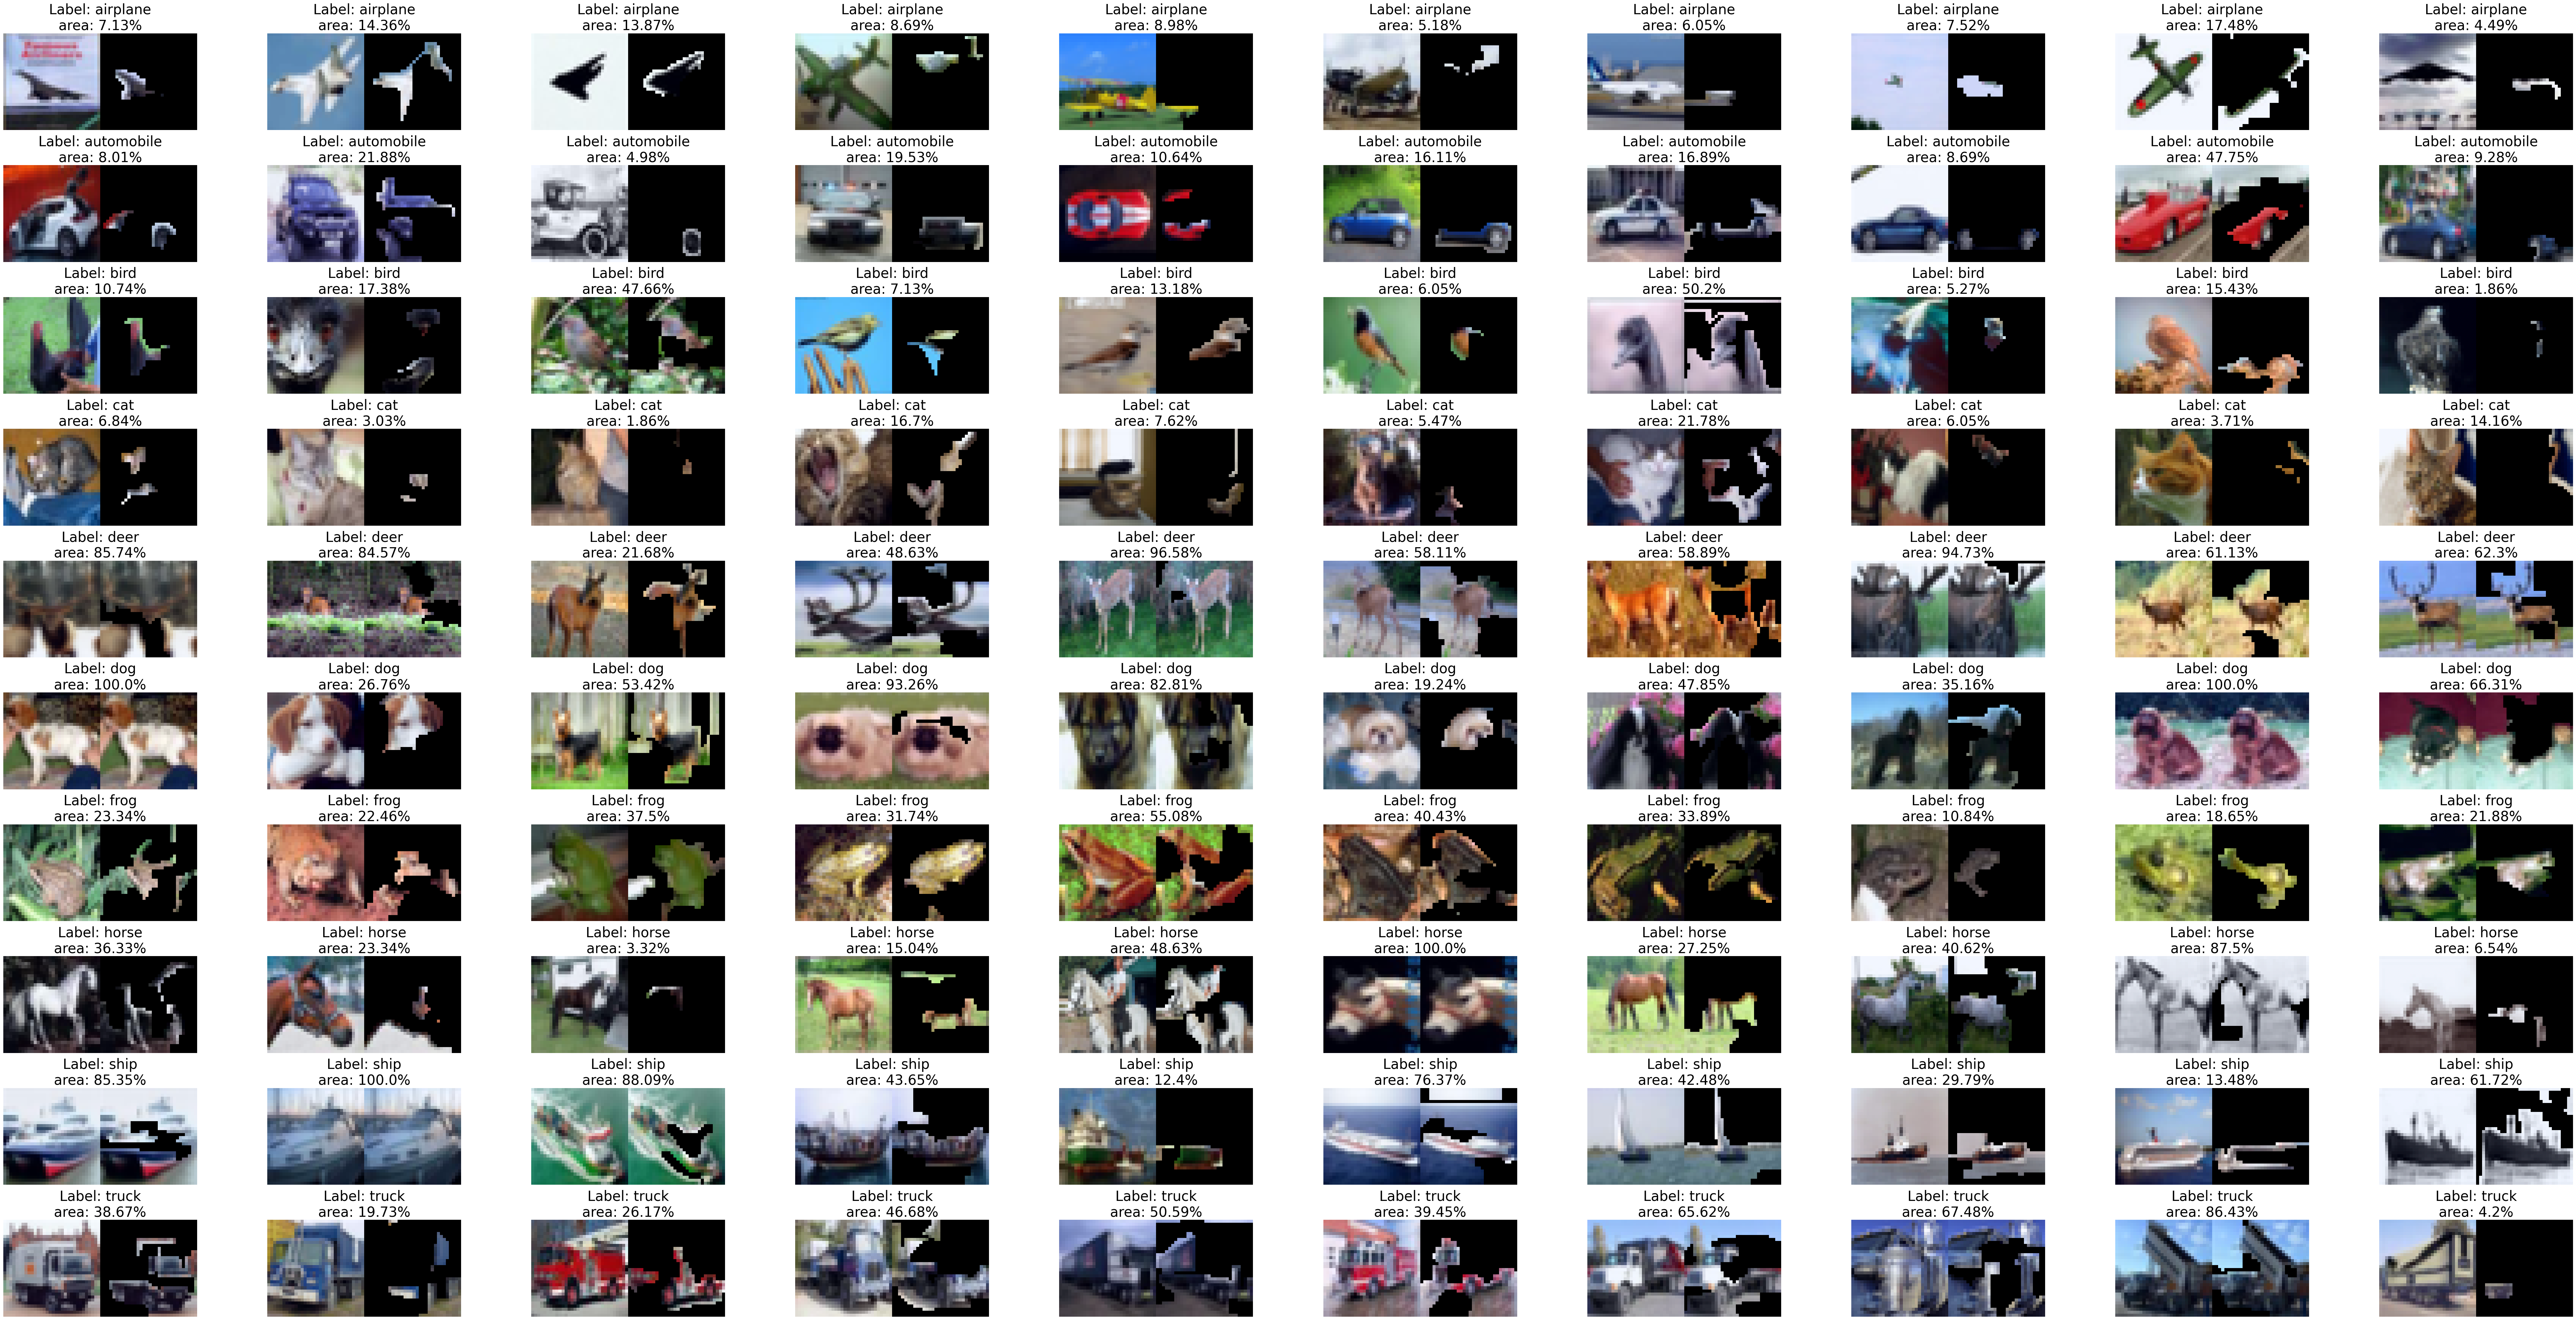

In [ ]:
image_tensor, labels = next(iter(test_loader))
num_classes = 10
max_per_class = 10
rows=10
cols=10
run_XRAI(image_tensor, labels, num_classes, max_per_class,rows,cols,model)

